In [46]:
import pandas as pd
import numpy as np

df = pd.read_parquet('../frequentation_data.parquet')

df.head()

,Date Article,Période,Année Courante,Année Précédente,Évolution (%)
0,2025-04-03,janvier,13.81,13.71,+0.8
1,2025-04-03,février,14.51,15.06,-3.7
2,2025-04-03,mars,12.53,15.19,-17.5
3,2025-04-03,trois premiers mois,40.85,43.96,-7.1
4,2025-04-03,année glissante (d’avril n-1 à mars n),178.41,175.79,+1.5


In [47]:
df['Date Article']= pd.to_datetime(df['Date Article'])


df = df.sort_values('Date Article', ascending=True)

In [48]:
df.head()

,Date Article,Période,Année Courante,Année Précédente,Évolution (%)
1499,2010-12-08,Juin,10.85,11.19,-3.1
1496,2010-12-08,Mars,18.67,17.75,+5.2
1497,2010-12-08,Avril,18.58,17.39,+6.8
1498,2010-12-08,Mai,15.95,14.94,+6.6
1500,2010-12-08,Juillet,18.39,20.88,-11.9


In [49]:
df.shape

(1526, 5)

In [50]:
fr_month = {
    'janvier', 'février', 'mars', 
    'avril', 'mai', 'juin', 
    'juillet', 'août', 'septembre', 
    'octobre', 'novembre', 'décembre'
}

def make_month(x):
    if x["Période"].lower() in fr_month:
        return x["Période"].lower() + " " + str(x["Date Article"].year)
    else:
        return np.nan

df['month'] = df.apply(make_month, axis=1)

In [51]:
df.dropna(inplace=True)

In [52]:
df.shape

(1032, 6)

In [53]:
df.drop('Date Article', axis=1, inplace=True)
df.drop('Période', axis=1, inplace=True)
df.drop('Évolution (%)', axis=1, inplace=True)

In [54]:
df.drop_duplicates(inplace=True)

In [55]:
df.head(10)

,Année Courante,Année Précédente,month
1499,10.85,11.19,juin 2010
1496,18.67,17.75,mars 2010
1497,18.58,17.39,avril 2010
1498,15.95,14.94,mai 2010
1500,18.39,20.88,juillet 2010
1501,17.51,15.06,août 2010
1502,10.67,10.49,septembre 2010
1503,18.54,15.75,octobre 2010
1504,19.27,20.94,novembre 2010
1495,20.48,19.05,février 2010


In [56]:
df2 = df.copy()
df2['Année Courante']=df['Année Précédente']

In [57]:
df2.drop('Année Précédente', axis=1, inplace=True)

In [58]:
def precedant_year(x):
    year = int(x[-4:])-1
    return x[:-4] + str(year)

df2['month'] = df2['month'].apply(lambda x : precedant_year(x))

In [59]:
df2.head()

,Année Courante,month
1499,11.19,juin 2009
1496,17.75,mars 2009
1497,17.39,avril 2009
1498,14.94,mai 2009
1500,20.88,juillet 2009


In [60]:
df.drop('Année Précédente', axis=1, inplace=True)
df = pd.concat([df,df2])

In [61]:
df

,Année Courante,month
1499,10.85,juin 2010
1496,18.67,mars 2010
1497,18.58,avril 2010
1498,15.95,mai 2010
1500,18.39,juillet 2010
...,...,...
99,13.71,janvier 2024
17,13.71,janvier 2024
18,15.08,février 2024
2,15.19,mars 2024


In [62]:
df_final = df.groupby(['month']).mean()

In [63]:
df_final.reset_index(inplace=True)

In [64]:
df_final

,month,Année Courante
0,août 2009,14.905000
1,août 2010,16.740000
2,août 2011,17.312000
3,août 2012,14.958571
4,août 2013,14.898571
...,...,...
179,septembre 2020,5.590000
180,septembre 2021,9.220000
181,septembre 2022,7.866000
182,septembre 2023,8.521429


In [65]:
mois_fr_to_en = {
    'janvier': 'January', 'février': 'February', 'mars': 'March', 
    'avril': 'April', 'mai': 'May', 'juin': 'June', 
    'juillet': 'July', 'août': 'August', 'septembre': 'September', 
    'octobre': 'October', 'novembre': 'November', 'décembre': 'December'
}

def convert_fr_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    
    for fr, en in mois_fr_to_en.items():
        date_str = date_str.replace(fr, en)
    
    return pd.to_datetime(date_str, format='%B %Y')

df_final['month'] = df_final['month'].apply(convert_fr_date)
df_final.sort_values('month', inplace=True)

In [66]:
df_final['box_office']=df_final['Année Courante']
df_final.drop('Année Courante', axis=1, inplace=True)
df = df_final

In [67]:
print(df_final.dtypes)

month         datetime64[ns]
box_office           float64
dtype: object


In [68]:
print(df_final.head(300))

         month  box_office
57  2009-01-01   15.148333
41  2009-02-01   19.348000
121 2009-03-01   20.087500
16  2009-04-01   16.975000
105 2009-05-01   14.528333
..         ...         ...
151 2024-11-01   16.405000
40  2024-12-01   19.145000
72  2025-01-01   13.820000
56  2025-02-01   14.495000
136 2025-03-01   12.530000

[184 rows x 2 columns]


In [69]:
df.set_index('month', inplace=True)

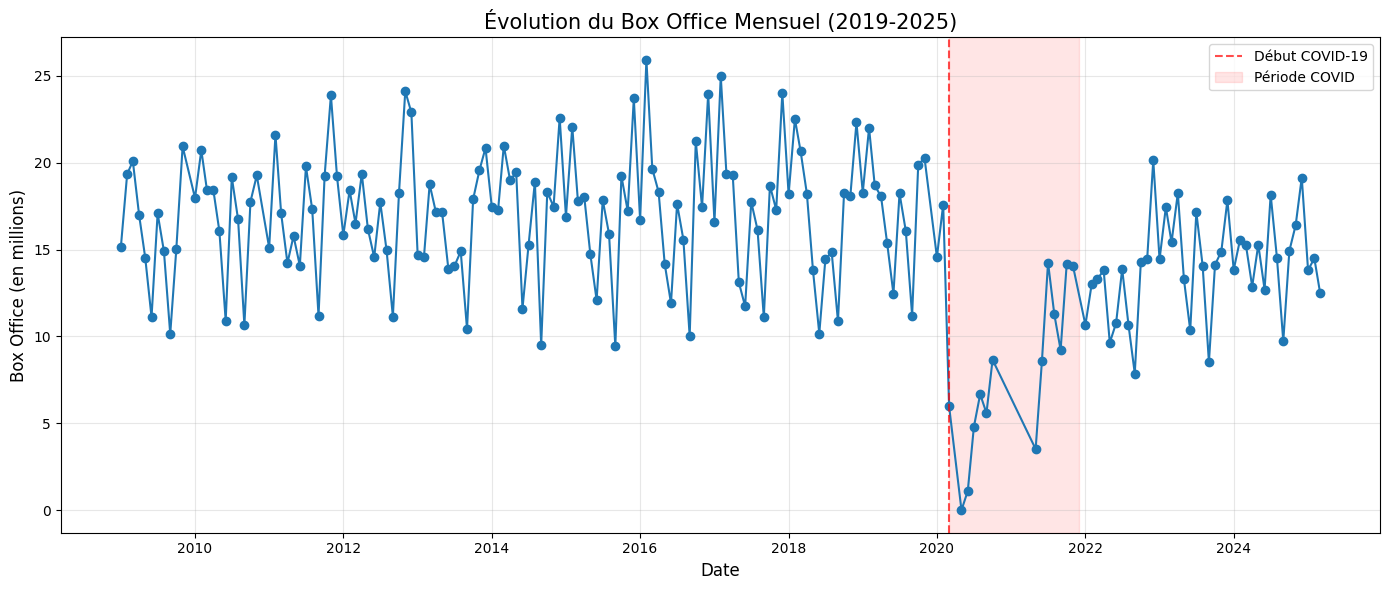

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['box_office'], marker='o', linestyle='-')
plt.title('Évolution du Box Office Mensuel (2019-2025)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', alpha=0.7, label='Début COVID-19')
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-12-01'), color='r', alpha=0.1, label='Période COVID')
plt.legend()
plt.tight_layout()
plt.show()

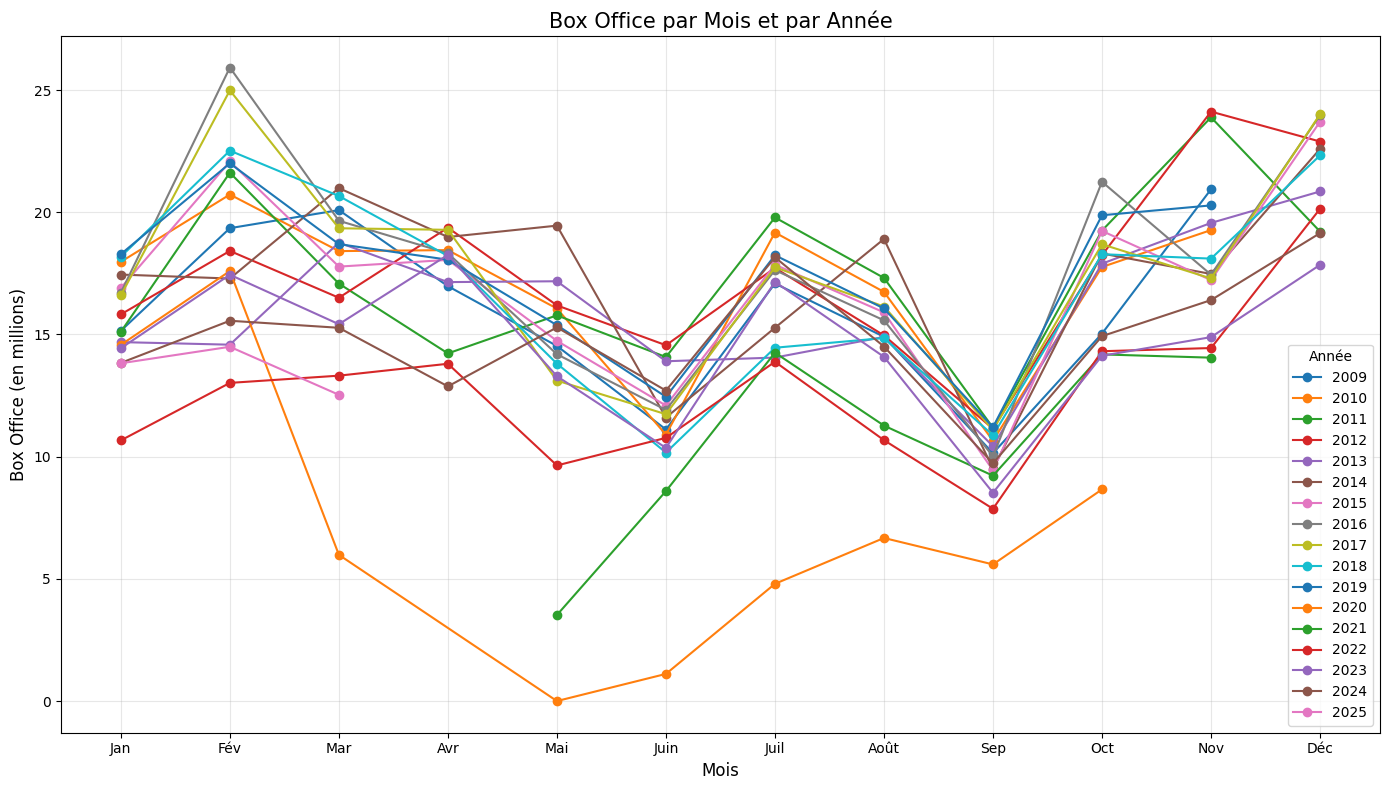

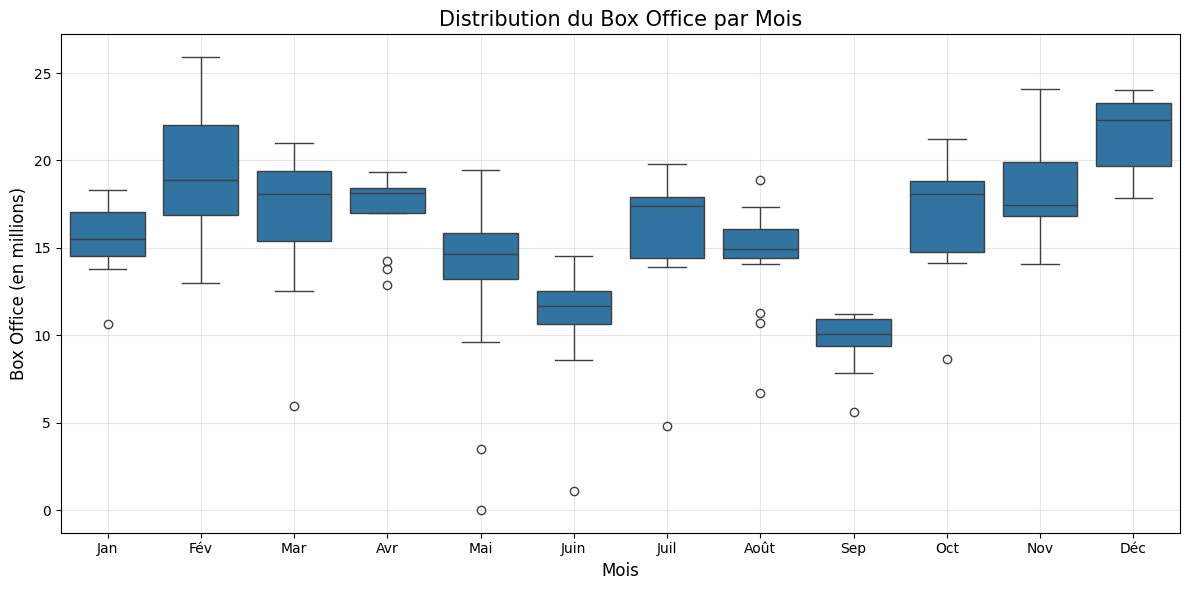

In [71]:
df['year'] = df.index.year
df['month_num'] = df.index.month
import seaborn as sns

# Graphique par année
plt.figure(figsize=(14, 8))
years = sorted(df['year'].unique())
for year in years:
    data_year = df[df['year'] == year]
    plt.plot(data_year['month_num'], data_year['box_office'], marker='o', linestyle='-', label=str(year))

plt.title('Box Office par Mois et par Année', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.legend(title='Année')
plt.tight_layout()
plt.show()

# 3. Distribution des valeurs par boxplot pour voir les variations
plt.figure(figsize=(12, 6))
sns.boxplot(x='month_num', y='box_office', data=df)
plt.title('Distribution du Box Office par Mois', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

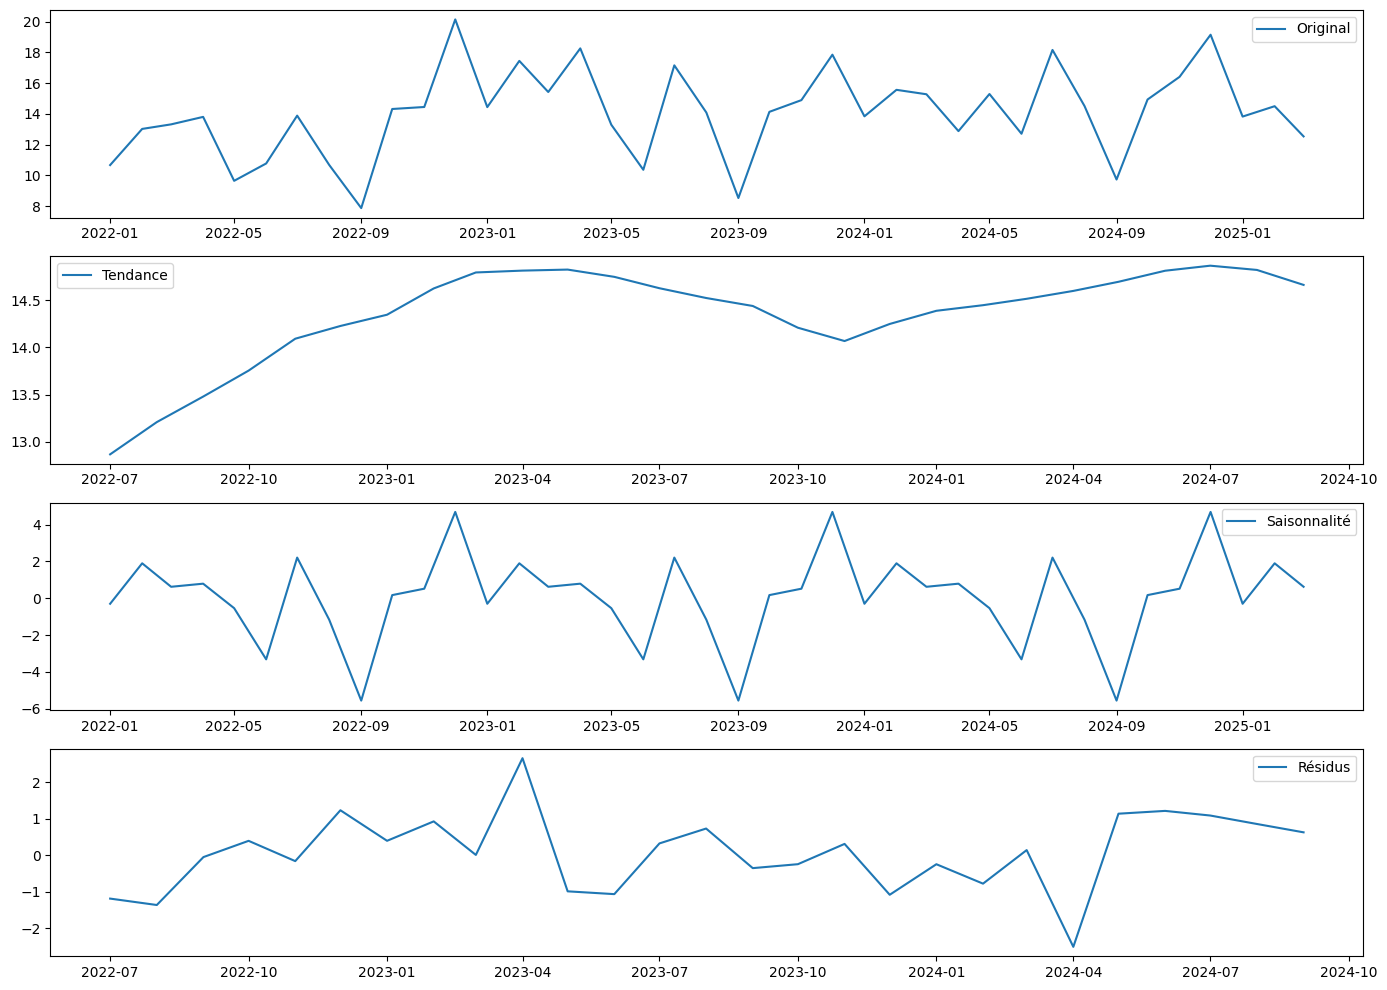

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

full_idx = pd.date_range(start='2010-12-01', end='2025-03-01', freq='MS')
ts_full = df.reindex(full_idx)

# Interpolation simple pour remplir les valeurs manquantes (uniquement pour l'analyse)
ts_filled = ts_full.interpolate(method='linear')

# Décomposition de la série temporelle (après 2021 pour éviter l'impact majeur de la COVID)
post_covid = ts_filled.loc['2022-01-01':]
decomposition = seasonal_decompose(post_covid['box_office'], model='additive', period=12)

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(post_covid.index, post_covid['box_office'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendance')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Saisonnalité')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Résidus')
plt.legend()
plt.tight_layout()
plt.show()

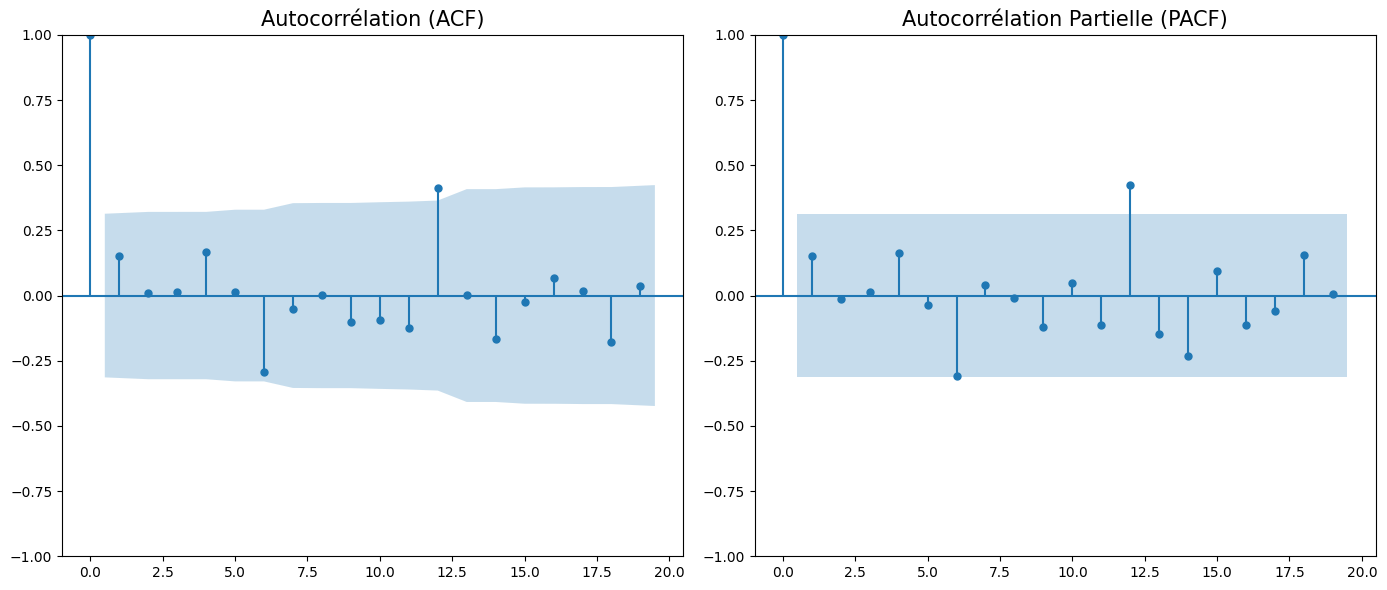

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(post_covid['box_office'].dropna(), lags=19, ax=plt.gca())
plt.title('Autocorrélation (ACF)', fontsize=15)
plt.subplot(122)
plot_pacf(post_covid['box_office'].dropna(), lags=19, ax=plt.gca())
plt.title('Autocorrélation Partielle (PACF)', fontsize=15)
plt.tight_layout()
plt.show()

In [74]:
train_data = ts_filled.loc['2022-01-01':'2024-12-01', 'box_office']
test_data = ts_filled.loc['2025-01-01':'2025-03-01', 'box_office']

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, 
                order=(1, 1, 1),           # (p,d,q) - parties non saisonnières
                seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) - partie saisonnière
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                         box_office   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -18.987
Date:                            Wed, 09 Apr 2025   AIC                             47.975
Time:                                    09:19:18   BIC                             48.961
Sample:                                01-01-2022   HQIC                            45.846
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1854      0.549     -0.338      0.735      -1.261       0.890
ma.L1         -1.0000   8230.814   

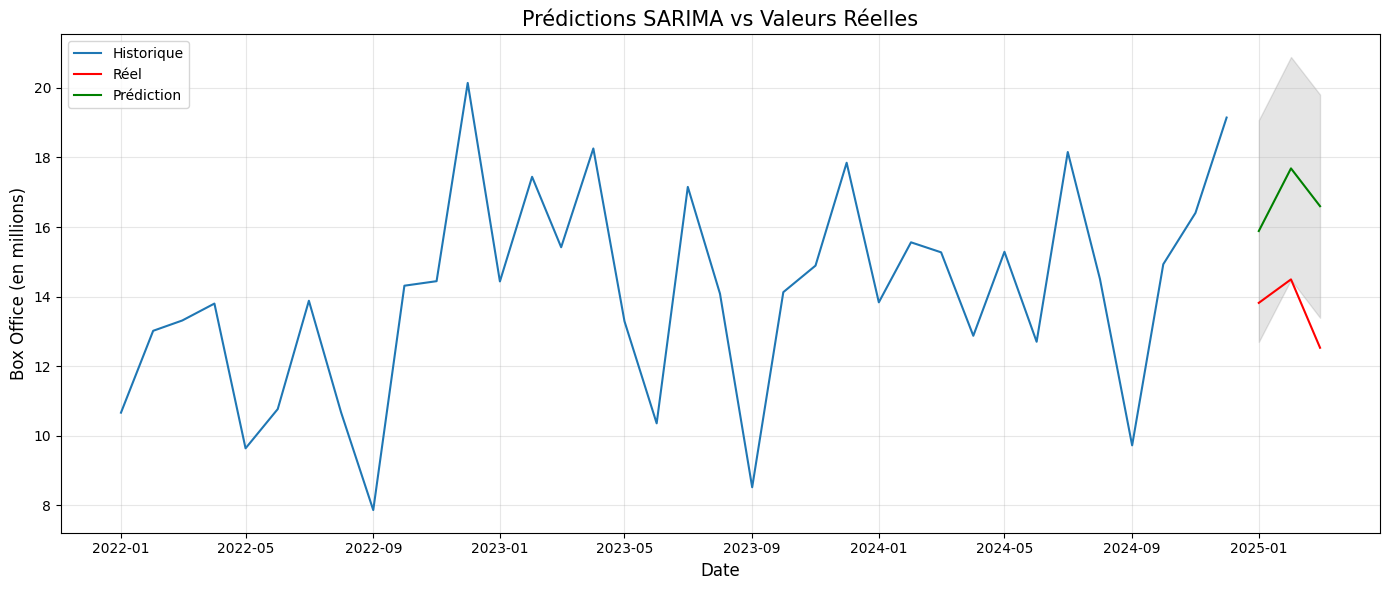

In [76]:
# Prédictions sur les données de test
pred = results.get_forecast(steps=len(test_data))
pred_ci = pred.conf_int()

# Visualisation des prédictions vs réelles
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(test_data.index, pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prédictions SARIMA vs Valeurs Réelles', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

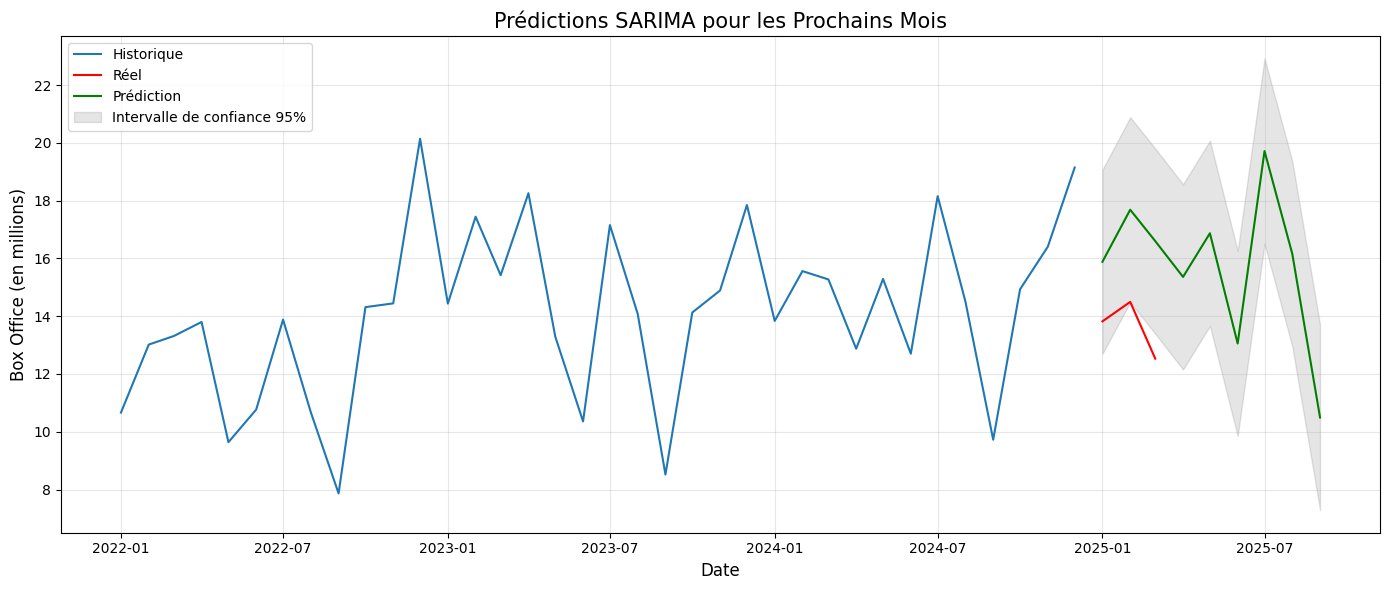

In [77]:
# Prédictions futures (6 mois)
future_steps = 6
future_pred = results.get_forecast(steps=len(test_data) + future_steps)
future_ci = future_pred.conf_int()

# Créer un index pour les prédictions futures
future_idx = pd.date_range(start='2025-01-01', periods=len(test_data) + future_steps, freq='MS')

# Visualisation incluant les prédictions futures
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(future_idx, future_pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(future_idx,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1], color='k', alpha=0.1, label='Intervalle de confiance 95%')
plt.title('Prédictions SARIMA pour les Prochains Mois', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
df_modified = df.copy()

# Identifier la période COVID
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2021-12-01')
covid_mask = (df.index >= covid_start) & (df.index <= covid_end)

In [79]:
# def check_missing_dates(df, freq='MS'):
#     """
#     Vérifie les dates manquantes dans une dataframe avec un index temporel.
    
#     Paramètres:
#     - df: DataFrame avec un index temporel
#     - freq: fréquence des données ('MS' pour début de mois)
    
#     Retourne:
#     - DataFrame avec les dates manquantes et leurs indices
#     """
#     # S'assurer que l'index est bien un DatetimeIndex
#     if not isinstance(df.index, pd.DatetimeIndex):
#         raise ValueError("L'index du DataFrame doit être un DatetimeIndex")
    
#     # Créer un index complet sur la période
#     full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    
#     # Trouver les dates manquantes
#     missing_dates = full_idx.difference(df.index)
    
#     # Afficher les résultats
#     print(f"Période analysée: {df.index.min().strftime('%Y-%m')} à {df.index.max().strftime('%Y-%m')}")
#     print(f"Nombre total de dates attendues: {len(full_idx)}")
#     print(f"Nombre de dates présentes: {len(df.index)}")
#     print(f"Nombre de dates manquantes: {len(missing_dates)}")
    
#     if len(missing_dates) > 0:
#         print("\nDates manquantes:")
#         for date in missing_dates:
#             print(f"- {date.strftime('%Y-%m')}")
    
#     return missing_dates

# check_missing_dates(df_modified)

In [80]:
def estimate_normal_value(date, df):
    month = date.month
    # Collecter les valeurs des mêmes mois des années précédentes (2017-2019)
    values = []
    for year in range(2017, 2020):
        comparable_date = pd.to_datetime(f"{year}-{month:02d}-01")
        if comparable_date in df.index and not pd.isna(df.loc[comparable_date, 'box_office']):
            values.append(df.loc[comparable_date, 'box_office'])
    
    # Si nous avons des valeurs, calculer la moyenne
    if values:
        return np.mean(values)
    else:
        return None

# Appliquer le remplacement pour la période COVID
for date in df.loc[covid_mask].index:
    normal_value = estimate_normal_value(date, df)
    if normal_value is not None:
        df_modified.loc[date, 'box_office'] = normal_value

In [81]:
# def fill_missing_dates(df, method='interpolate'):
#     """
#     Complète les dates manquantes dans une dataframe.
    
#     Paramètres:
#     - df: DataFrame avec un index temporel
#     - missing_dates: liste des dates manquantes
#     - method: méthode de remplissage ('interpolate', 'seasonal_mean', 'seasonal_median')
    
#     Retourne:
#     - DataFrame complété
#     """
#     # Créer une copie du dataframe
#     df_filled = df.copy()
#     missing_dates = check_missing_dates(df)
    
#     # Ajouter les dates manquantes avec des NaN
#     for date in missing_dates:
#         df_filled.loc[date] = np.nan
    
#     # Trier l'index
#     df_filled = df_filled.sort_index()
    
#     if method == 'interpolate':
#         # Interpolation linéaire simple
#         df_filled = df_filled.interpolate(method='linear')
#         print("Dates manquantes complétées par interpolation linéaire.")
    
#     elif method == 'seasonal_mean':
#         # Remplacer par la moyenne du même mois des autres années
#         for date in missing_dates:
#             same_month_values = df[df.index.month == date.month]['box_office']
#             if len(same_month_values) > 0:
#                 df_filled.loc[date, 'box_office'] = same_month_values.mean()
#                 print(f"Date {date.strftime('%Y-%m')} complétée avec la moyenne des mêmes mois: {df_filled.loc[date, 'box_office']:.2f}")
#             else:
#                 # Fallback sur l'interpolation si pas de données pour ce mois
#                 df_filled = df_filled.interpolate(method='linear')
#                 print(f"Date {date.strftime('%Y-%m')} complétée par interpolation: {df_filled.loc[date, 'box_office']:.2f}")
    
#     elif method == 'seasonal_median':
#         # Remplacer par la médiane du même mois des autres années
#         for date in missing_dates:
#             same_month_values = df[df.index.month == date.month]['box_office']
#             if len(same_month_values) > 0:
#                 df_filled.loc[date, 'box_office'] = same_month_values.median()
#                 print(f"Date {date.strftime('%Y-%m')} complétée avec la médiane des mêmes mois: {df_filled.loc[date, 'box_office']:.2f}")
#             else:
#                 # Fallback sur l'interpolation si pas de données pour ce mois
#                 df_filled = df_filled.interpolate(method='linear')
#                 print(f"Date {date.strftime('%Y-%m')} complétée par interpolation: {df_filled.loc[date, 'box_office']:.2f}")
    
#     return df_filled

# df_modified = fill_missing_dates(df_modified)

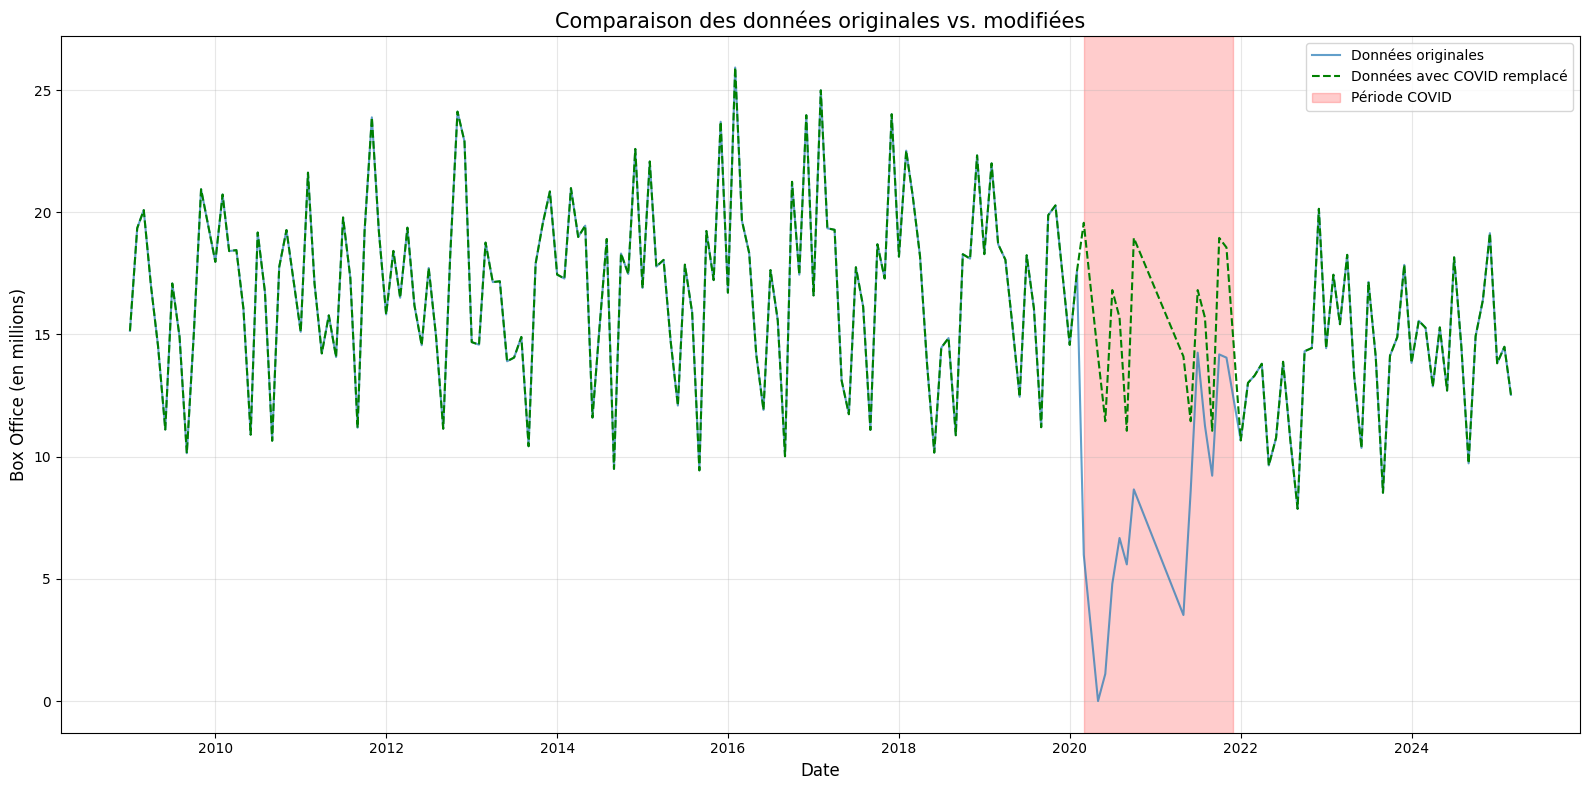

In [82]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['box_office'], label='Données originales', alpha=0.7)
plt.plot(df_modified.index, df_modified['box_office'], label='Données avec COVID remplacé', 
         color='green', linestyle='--')
plt.title('Comparaison des données originales vs. modifiées', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.axvspan(covid_start, covid_end, color='red', alpha=0.2, label='Période COVID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

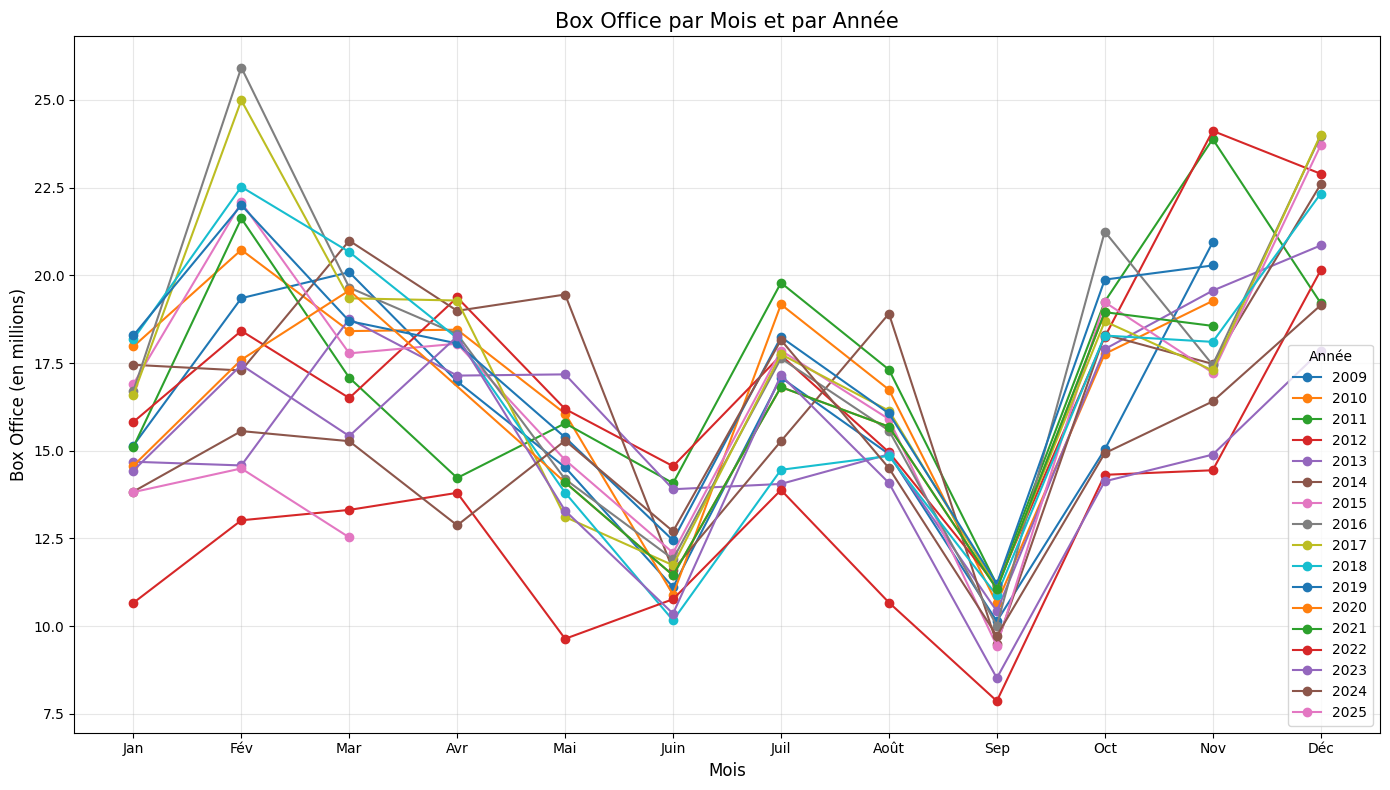

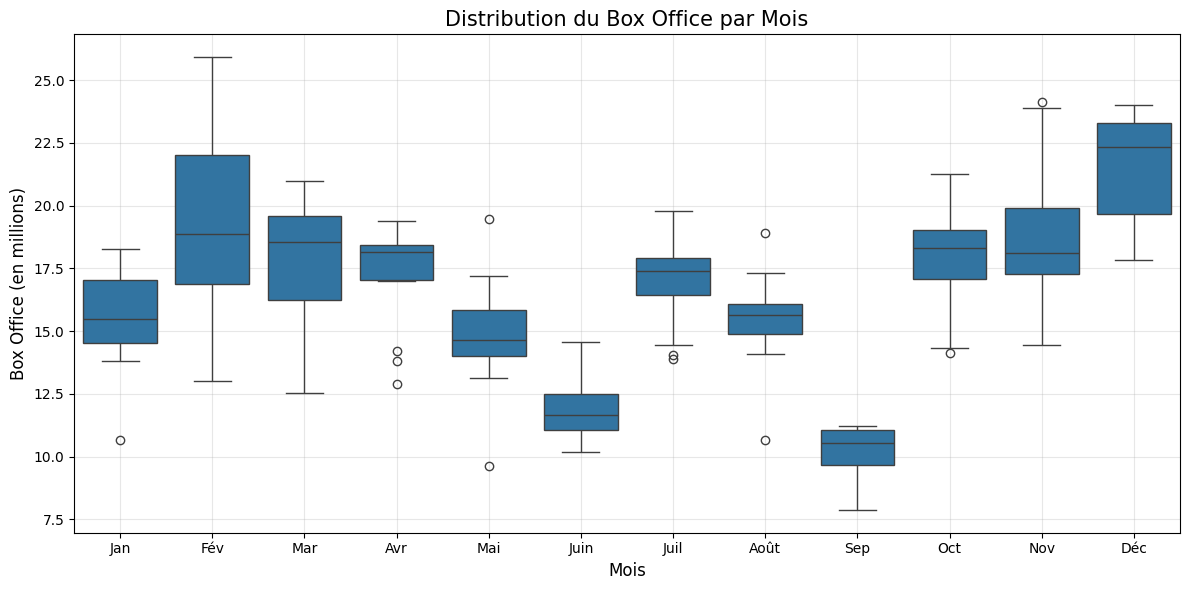

In [83]:
df_modified['year'] = df_modified.index.year
df_modified['month_num'] = df_modified.index.month
import seaborn as sns

# Graphique par année
plt.figure(figsize=(14, 8))
years = sorted(df_modified['year'].unique())
for year in years:
    data_year = df_modified[df_modified['year'] == year]
    plt.plot(data_year['month_num'], data_year['box_office'], marker='o', linestyle='-', label=str(year))

plt.title('Box Office par Mois et par Année', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.legend(title='Année')
plt.tight_layout()
plt.show()

# 3. Distribution des valeurs par boxplot pour voir les variations
plt.figure(figsize=(12, 6))
sns.boxplot(x='month_num', y='box_office', data=df_modified)
plt.title('Distribution du Box Office par Mois', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
train_data.isna().count()

np.int64(36)

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_data = df_modified.loc[:'2024-12-01', 'box_office']
test_data = df_modified.loc['2025-01-01':, 'box_office']

# Fonction pour évaluer un modèle SARIMA avec des paramètres donnés
def evaluate_sarima_model(train, test, order, seasonal_order):
    try:
        # Ajuster le modèle
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order, 
                      enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Faire des prédictions
        predictions = model_fit.forecast(len(test))
        
        # Calculer les métriques d'erreur
        mse = mean_squared_error(test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, predictions)
        
        return {'order': order, 'seasonal_order': seasonal_order, 
                'rmse': rmse, 'mae': mae, 'model': model_fit}
    except:
        return None

# Définir les paramètres à tester
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s_values = [12]  # Période saisonnière fixée à 12 mois

# Grille de recherche limitée (pour éviter d'exécuter trop de modèles)
# Vous pouvez augmenter les combinaisons si nécessaire
param_combinations = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            param_combinations.append((p, d, q, P, D, Q, s))

# # Limiter le nombre de combinaisons pour des raisons de temps d'exécution
# # En pratique, vous pourriez vouloir tester toutes les combinaisons
# np.random.seed(42)
# if len(param_combinations) > 20:
#     param_combinations = np.random.choice(param_combinations, size=20, replace=False)

# Évaluer chaque combinaison de paramètres
results = []
for params in param_combinations:
    p, d, q, P, D, Q, s = params
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    result = evaluate_sarima_model(train_data, test_data, order, seasonal_order)
    if result is not None:
        results.append(result)
        print(f"SARIMA{order}x{seasonal_order} - RMSE: {result['rmse']:.4f}, MAE: {result['mae']:.4f}")

# Trier les résultats par RMSE
results.sort(key=lambda x: x['rmse'])

# Afficher les meilleurs modèles
print("\nMeilleurs modèles SARIMA:")
for i, result in enumerate(results[:5]):
    print(f"{i+1}. SARIMA{result['order']}x{result['seasonal_order']} - RMSE: {result['rmse']:.4f}, MAE: {result['mae']:.4f}")


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/ba

SARIMA(0, 0, 0)x(0, 0, 0, 12) - RMSE: 13.6394, MAE: 13.6150
SARIMA(0, 0, 0)x(0, 0, 1, 12) - RMSE: 9.7665, MAE: 9.4123
SARIMA(0, 0, 0)x(0, 1, 0, 12) - RMSE: 1.6983, MAE: 1.2742
SARIMA(0, 0, 0)x(0, 1, 1, 12) - RMSE: 1.6963, MAE: 1.3385


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 0)x(1, 0, 0, 12) - RMSE: 1.4533, MAE: 1.1354
SARIMA(0, 0, 0)x(1, 0, 1, 12) - RMSE: 1.4106, MAE: 1.1936
SARIMA(0, 0, 0)x(1, 1, 0, 12) - RMSE: 1.8146, MAE: 1.4633


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 0)x(1, 1, 1, 12) - RMSE: 1.5696, MAE: 1.2324
SARIMA(0, 0, 1)x(0, 0, 0, 12) - RMSE: 11.3530, MAE: 10.4829
SARIMA(0, 0, 1)x(0, 0, 1, 12) - RMSE: 7.4847, MAE: 6.1563


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 1)x(0, 1, 0, 12) - RMSE: 1.6983, MAE: 1.2704
SARIMA(0, 0, 1)x(0, 1, 1, 12) - RMSE: 1.6831, MAE: 1.3065


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 1)x(1, 0, 0, 12) - RMSE: 1.4581, MAE: 1.1437


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 1)x(1, 0, 1, 12) - RMSE: 1.3841, MAE: 1.1582
SARIMA(0, 0, 1)x(1, 1, 0, 12) - RMSE: 1.8269, MAE: 1.5009


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 1)x(1, 1, 1, 12) - RMSE: 1.5847, MAE: 1.2341
SARIMA(0, 0, 2)x(0, 0, 0, 12) - RMSE: 9.0993, MAE: 8.2193


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 2)x(0, 0, 1, 12) - RMSE: 6.3475, MAE: 5.3199
SARIMA(0, 0, 2)x(0, 1, 0, 12) - RMSE: 1.6587, MAE: 1.2482
SARIMA(0, 0, 2)x(0, 1, 1, 12) - RMSE: 1.6806, MAE: 1.3166


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 2)x(1, 0, 0, 12) - RMSE: 1.4562, MAE: 1.1178


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 2)x(1, 0, 1, 12) - RMSE: 1.4151, MAE: 1.1758


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 2)x(1, 1, 0, 12) - RMSE: 1.7977, MAE: 1.4175


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 0, 2)x(1, 1, 1, 12) - RMSE: 1.6065, MAE: 1.2582
SARIMA(0, 1, 0)x(0, 0, 0, 12) - RMSE: 5.5898, MAE: 5.5300
SARIMA(0, 1, 0)x(0, 0, 1, 12) - RMSE: 4.4804, MAE: 4.3673
SARIMA(0, 1, 0)x(0, 1, 0, 12) - RMSE: 2.8069, MAE: 2.5726
SARIMA(0, 1, 0)x(0, 1, 1, 12) - RMSE: 2.2507, MAE: 1.9862
SARIMA(0, 1, 0)x(1, 0, 0, 12) - RMSE: 4.0680, MAE: 3.9636


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 0)x(1, 0, 1, 12) - RMSE: 4.0259, MAE: 3.9204
SARIMA(0, 1, 0)x(1, 1, 0, 12) - RMSE: 2.4122, MAE: 2.1661


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 0)x(1, 1, 1, 12) - RMSE: 2.2432, MAE: 1.9797
SARIMA(0, 1, 1)x(0, 0, 0, 12) - RMSE: 1.4339, MAE: 1.1797
SARIMA(0, 1, 1)x(0, 0, 1, 12) - RMSE: 1.1976, MAE: 0.9317
SARIMA(0, 1, 1)x(0, 1, 0, 12) - RMSE: 1.6185, MAE: 1.2276


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 1)x(0, 1, 1, 12) - RMSE: 1.5289, MAE: 1.2659
SARIMA(0, 1, 1)x(1, 0, 0, 12) - RMSE: 1.6075, MAE: 1.3010


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 1)x(1, 0, 1, 12) - RMSE: 1.6060, MAE: 1.2966
SARIMA(0, 1, 1)x(1, 1, 0, 12) - RMSE: 1.6573, MAE: 1.3013


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 1)x(1, 1, 1, 12) - RMSE: 1.5288, MAE: 1.2658
SARIMA(0, 1, 2)x(0, 0, 0, 12) - RMSE: 1.6697, MAE: 1.4581
SARIMA(0, 1, 2)x(0, 0, 1, 12) - RMSE: 1.2450, MAE: 1.0280


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 2)x(0, 1, 0, 12) - RMSE: 1.6127, MAE: 1.2342


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 2)x(0, 1, 1, 12) - RMSE: 1.4314, MAE: 1.1907
SARIMA(0, 1, 2)x(1, 0, 0, 12) - RMSE: 1.6138, MAE: 1.3176


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 2)x(1, 0, 1, 12) - RMSE: 1.6107, MAE: 1.3088


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 2)x(1, 1, 0, 12) - RMSE: 1.6712, MAE: 1.3145


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(0, 1, 2)x(1, 1, 1, 12) - RMSE: 1.4315, MAE: 1.1908
SARIMA(1, 0, 0)x(0, 0, 0, 12) - RMSE: 4.2421, MAE: 4.1954
SARIMA(1, 0, 0)x(0, 0, 1, 12) - RMSE: 2.8983, MAE: 2.8041
SARIMA(1, 0, 0)x(0, 1, 0, 12) - RMSE: 1.6984, MAE: 1.2698
SARIMA(1, 0, 0)x(0, 1, 1, 12) - RMSE: 1.6850, MAE: 1.3097


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 0)x(1, 0, 0, 12) - RMSE: 1.4376, MAE: 1.1296
SARIMA(1, 0, 0)x(1, 0, 1, 12) - RMSE: 1.3855, MAE: 1.1638
SARIMA(1, 0, 0)x(1, 1, 0, 12) - RMSE: 1.8225, MAE: 1.4947


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 0)x(1, 1, 1, 12) - RMSE: 1.5741, MAE: 1.2207
SARIMA(1, 0, 1)x(0, 0, 0, 12) - RMSE: 1.2332, MAE: 0.9311


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(0, 0, 1, 12) - RMSE: 1.1719, MAE: 0.9214
SARIMA(1, 0, 1)x(0, 1, 0, 12) - RMSE: 1.6977, MAE: 1.2710


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(0, 1, 1, 12) - RMSE: 1.6979, MAE: 1.3283


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(1, 0, 0, 12) - RMSE: 1.3215, MAE: 0.9318


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(1, 0, 1, 12) - RMSE: 1.4084, MAE: 1.1750


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(1, 1, 0, 12) - RMSE: 1.8094, MAE: 1.4449


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 1)x(1, 1, 1, 12) - RMSE: 1.6081, MAE: 1.2506
SARIMA(1, 0, 2)x(0, 0, 0, 12) - RMSE: 1.4828, MAE: 1.2389


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.

SARIMA(1, 0, 2)x(0, 0, 1, 12) - RMSE: 1.2334, MAE: 1.0424
SARIMA(1, 0, 2)x(0, 1, 0, 12) - RMSE: 1.7066, MAE: 1.3480


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 2)x(0, 1, 1, 12) - RMSE: 1.7032, MAE: 1.3394


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 2)x(1, 0, 0, 12) - RMSE: 1.3230, MAE: 0.9537


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 2)x(1, 0, 1, 12) - RMSE: 1.3585, MAE: 0.9983
SARIMA(1, 0, 2)x(1, 1, 0, 12) - RMSE: 1.8022, MAE: 1.4115


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 0, 2)x(1, 1, 1, 12) - RMSE: 1.6168, MAE: 1.2656
SARIMA(1, 1, 0)x(0, 0, 0, 12) - RMSE: 4.6845, MAE: 4.6179
SARIMA(1, 1, 0)x(0, 0, 1, 12) - RMSE: 3.6749, MAE: 3.5407
SARIMA(1, 1, 0)x(0, 1, 0, 12) - RMSE: 2.8705, MAE: 2.6450
SARIMA(1, 1, 0)x(0, 1, 1, 12) - RMSE: 2.1962, MAE: 1.9257


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 0)x(1, 0, 0, 12) - RMSE: 3.6851, MAE: 3.5640
SARIMA(1, 1, 0)x(1, 0, 1, 12) - RMSE: 3.6957, MAE: 3.5745
SARIMA(1, 1, 0)x(1, 1, 0, 12) - RMSE: 2.6964, MAE: 2.4949


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 0)x(1, 1, 1, 12) - RMSE: 1.9626, MAE: 1.6946
SARIMA(1, 1, 1)x(0, 0, 0, 12) - RMSE: 1.7220, MAE: 1.5353


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 1)x(0, 0, 1, 12) - RMSE: 1.2629, MAE: 1.0292
SARIMA(1, 1, 1)x(0, 1, 0, 12) - RMSE: 1.6144, MAE: 1.2314


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 1)x(0, 1, 1, 12) - RMSE: 1.4289, MAE: 1.1931
SARIMA(1, 1, 1)x(1, 0, 0, 12) - RMSE: 1.6137, MAE: 1.3146


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 1)x(1, 0, 1, 12) - RMSE: 1.6082, MAE: 1.3021
SARIMA(1, 1, 1)x(1, 1, 0, 12) - RMSE: 1.6751, MAE: 1.3189


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 1)x(1, 1, 1, 12) - RMSE: 1.1571, MAE: 0.9766
SARIMA(1, 1, 2)x(0, 0, 0, 12) - RMSE: 1.7657, MAE: 1.5951


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(0, 0, 1, 12) - RMSE: 1.3492, MAE: 1.1744
SARIMA(1, 1, 2)x(0, 1, 0, 12) - RMSE: 1.6326, MAE: 1.2455


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(0, 1, 1, 12) - RMSE: 1.4588, MAE: 1.2093


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(1, 0, 0, 12) - RMSE: 1.6137, MAE: 1.3146


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(1, 0, 1, 12) - RMSE: 1.6475, MAE: 1.3386


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(1, 1, 0, 12) - RMSE: 1.6642, MAE: 1.3173


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(1, 1, 2)x(1, 1, 1, 12) - RMSE: 1.1786, MAE: 0.9718
SARIMA(2, 0, 0)x(0, 0, 0, 12) - RMSE: 4.0384, MAE: 3.9906
SARIMA(2, 0, 0)x(0, 0, 1, 12) - RMSE: 2.9439, MAE: 2.8339
SARIMA(2, 0, 0)x(0, 1, 0, 12) - RMSE: 1.6871, MAE: 1.2920


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 0)x(0, 1, 1, 12) - RMSE: 1.6717, MAE: 1.3101
SARIMA(2, 0, 0)x(1, 0, 0, 12) - RMSE: 1.4923, MAE: 1.1766


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 0)x(1, 0, 1, 12) - RMSE: 1.4157, MAE: 1.1895
SARIMA(2, 0, 0)x(1, 1, 0, 12) - RMSE: 1.7949, MAE: 1.4217


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 0)x(1, 1, 1, 12) - RMSE: 1.5888, MAE: 1.2433
SARIMA(2, 0, 1)x(0, 0, 0, 12) - RMSE: 1.5279, MAE: 1.3157


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 1)x(0, 0, 1, 12) - RMSE: 1.2190, MAE: 1.0181
SARIMA(2, 0, 1)x(0, 1, 0, 12) - RMSE: 1.7567, MAE: 1.3804


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 1)x(0, 1, 1, 12) - RMSE: 1.7060, MAE: 1.3410


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 1)x(1, 0, 0, 12) - RMSE: 1.3606, MAE: 0.9932


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.

SARIMA(2, 0, 1)x(1, 0, 1, 12) - RMSE: 1.3592, MAE: 0.9918


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 1)x(1, 1, 0, 12) - RMSE: 1.8061, MAE: 1.4050


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 1)x(1, 1, 1, 12) - RMSE: 1.7021, MAE: 1.3506
SARIMA(2, 0, 2)x(0, 0, 0, 12) - RMSE: 1.4694, MAE: 1.2105


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(0, 0, 1, 12) - RMSE: 1.2438, MAE: 1.0649


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(0, 1, 0, 12) - RMSE: 1.7189, MAE: 1.2831


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(0, 1, 1, 12) - RMSE: 1.7559, MAE: 1.3913


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(1, 0, 0, 12) - RMSE: 1.3680, MAE: 1.0070


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.

SARIMA(2, 0, 2)x(1, 0, 1, 12) - RMSE: 1.3804, MAE: 1.0045


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(1, 1, 0, 12) - RMSE: 1.8429, MAE: 1.4349


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 0, 2)x(1, 1, 1, 12) - RMSE: 2.0192, MAE: 1.6319
SARIMA(2, 1, 0)x(0, 0, 0, 12) - RMSE: 3.9765, MAE: 3.8231
SARIMA(2, 1, 0)x(0, 0, 1, 12) - RMSE: 2.9962, MAE: 2.6285
SARIMA(2, 1, 0)x(0, 1, 0, 12) - RMSE: 2.7749, MAE: 2.4933


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 0)x(0, 1, 1, 12) - RMSE: 2.6456, MAE: 2.3880
SARIMA(2, 1, 0)x(1, 0, 0, 12) - RMSE: 3.0779, MAE: 2.8180
SARIMA(2, 1, 0)x(1, 0, 1, 12) - RMSE: 3.0925, MAE: 2.8023


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 0)x(1, 1, 0, 12) - RMSE: 2.7505, MAE: 2.4963


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 0)x(1, 1, 1, 12) - RMSE: 2.5571, MAE: 2.2996
SARIMA(2, 1, 1)x(0, 0, 0, 12) - RMSE: 1.7382, MAE: 1.5589


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 1)x(0, 0, 1, 12) - RMSE: 1.2431, MAE: 1.0561
SARIMA(2, 1, 1)x(0, 1, 0, 12) - RMSE: 2.7058, MAE: 2.4042


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 1)x(0, 1, 1, 12) - RMSE: 1.6331, MAE: 1.3152
SARIMA(2, 1, 1)x(1, 0, 0, 12) - RMSE: 1.5682, MAE: 1.1446


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 1)x(1, 0, 1, 12) - RMSE: 1.5674, MAE: 1.1432


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 1)x(1, 1, 0, 12) - RMSE: 1.8015, MAE: 1.4142


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 1)x(1, 1, 1, 12) - RMSE: 1.6334, MAE: 1.3155
SARIMA(2, 1, 2)x(0, 0, 0, 12) - RMSE: 4.0377, MAE: 3.6935


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 2)x(0, 0, 1, 12) - RMSE: 1.3647, MAE: 1.2022
SARIMA(2, 1, 2)x(0, 1, 0, 12) - RMSE: 1.6861, MAE: 1.3521


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 2)x(0, 1, 1, 12) - RMSE: 1.6798, MAE: 1.3492


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 2)x(1, 0, 0, 12) - RMSE: 1.6772, MAE: 1.1977


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 2)x(1, 0, 1, 12) - RMSE: 1.6719, MAE: 1.1654


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sta

SARIMA(2, 1, 2)x(1, 1, 0, 12) - RMSE: 1.6998, MAE: 1.3657
SARIMA(2, 1, 2)x(1, 1, 1, 12) - RMSE: 1.3899, MAE: 1.0831

Meilleurs modèles SARIMA:
1. SARIMA(1, 1, 1)x(1, 1, 1, 12) - RMSE: 1.1571, MAE: 0.9766
2. SARIMA(1, 0, 1)x(0, 0, 1, 12) - RMSE: 1.1719, MAE: 0.9214
3. SARIMA(1, 1, 2)x(1, 1, 1, 12) - RMSE: 1.1786, MAE: 0.9718
4. SARIMA(0, 1, 1)x(0, 0, 1, 12) - RMSE: 1.1976, MAE: 0.9317
5. SARIMA(2, 0, 1)x(0, 0, 1, 12) - RMSE: 1.2190, MAE: 1.0181


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [86]:
best_model = results[0]['model']
print(f"\nMeilleur modèle sélectionné: SARIMA{results[0]['order']}x{results[0]['seasonal_order']}")
print(best_model.summary())


Meilleur modèle sélectionné: SARIMA(1, 1, 1)x(1, 1, 1, 12)
                                     SARIMAX Results                                      
Dep. Variable:                         box_office   No. Observations:                  181
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -382.539
Date:                            Wed, 09 Apr 2025   AIC                            775.078
Time:                                    09:19:48   BIC                            790.263
Sample:                                         0   HQIC                           781.246
                                            - 181                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0298      0.079      0.377      0.706

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


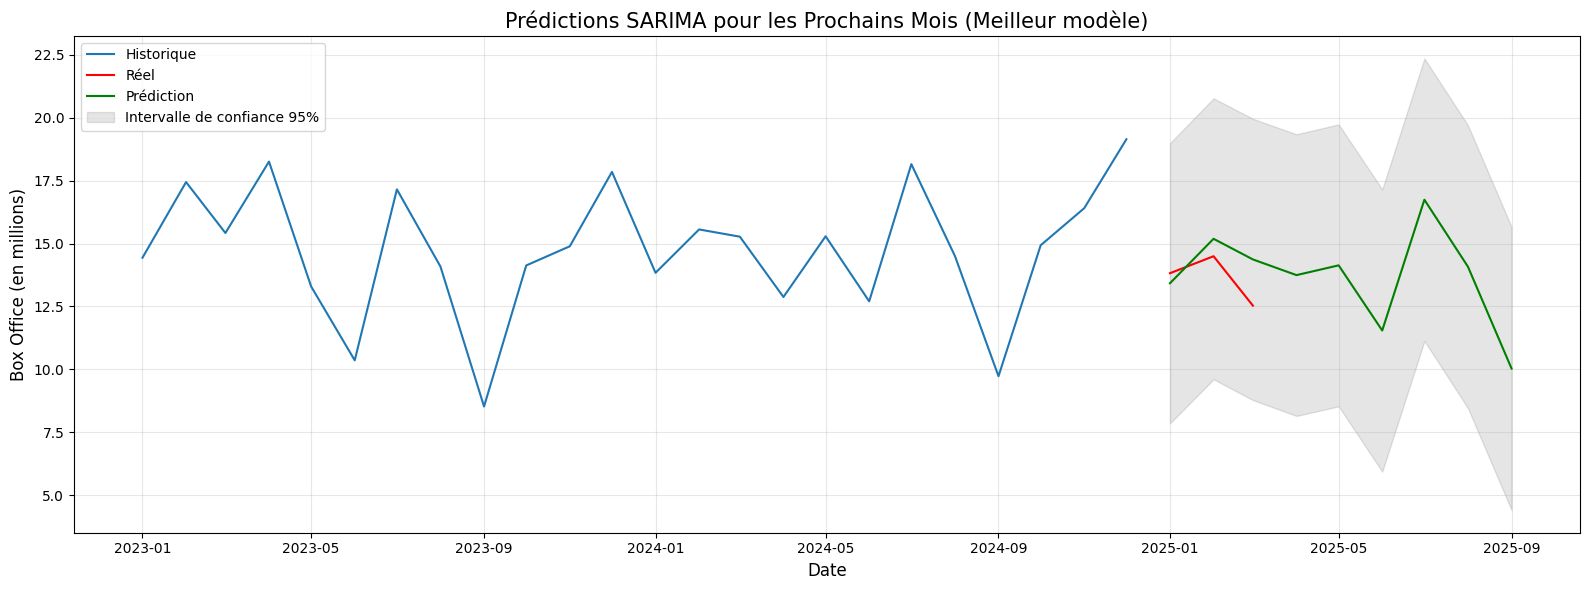

In [87]:
# Prédictions futures (6 mois)
future_steps = 6
future_index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')
future_pred = best_model.get_forecast(steps=len(test_data) + future_steps)
future_ci = future_pred.conf_int()

# Créer un index pour les prédictions futures
full_pred_index = pd.date_range(start=test_data.index[0], periods=len(test_data) + future_steps, freq='MS')

# Visualisation incluant les prédictions futures
plt.figure(figsize=(16, 6))
plt.plot(train_data.index[-24:], train_data[-24:], label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(full_pred_index, future_pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(full_pred_index,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1], color='k', alpha=0.1, label='Intervalle de confiance 95%')
plt.title('Prédictions SARIMA pour les Prochains Mois (Meilleur modèle)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()